## Задание 09
В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. 
Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones).  Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. 

* Скачайте данные самостоятельно. Объедините тестовую и обучающую выборку в одну (для задачи кластеризации тестовая выборка не понадобится). 

In [81]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
%matplotlib inline
import matplotlib.pyplot as plt

In [25]:
names_df = pd.read_csv('UCI HAR Dataset/features.txt', header=None, delimiter=" ", skipinitialspace = True)[1]
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', header=None, delimiter=" ",
                      dtype='float64', skipinitialspace = True, names=names_df)
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', header=0, delimiter=" ",
                     dtype='float64', skipinitialspace = True, names=names_df)
X = pd.concat([X_train, X_test])

(10298, 561)

* Определите число уникальных значений меток целевого класса. Будем использовать это значения для числа кластеров (в общем случае, число кластеров, мы естественно не знаем). 

In [26]:
n_clusters = 6 

* Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

* С помощью PCA, оставьте столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [51]:
pca = PCA(n_components=0.9)
pca.fit(X_scaled)

print("Components number: {}".format(pca.explained_variance_ratio_.shape[0]))

Components number: 65


* Сколько процентов дисперсии приходится на первую главную компоненту?

In [52]:
print("1st component variance percentage : {}".format(pca.explained_variance_ratio_[0]))

1st component variance percentage : 0.5073823196268734


* Визуализируйте данные в проекции на первые две главные компоненты.

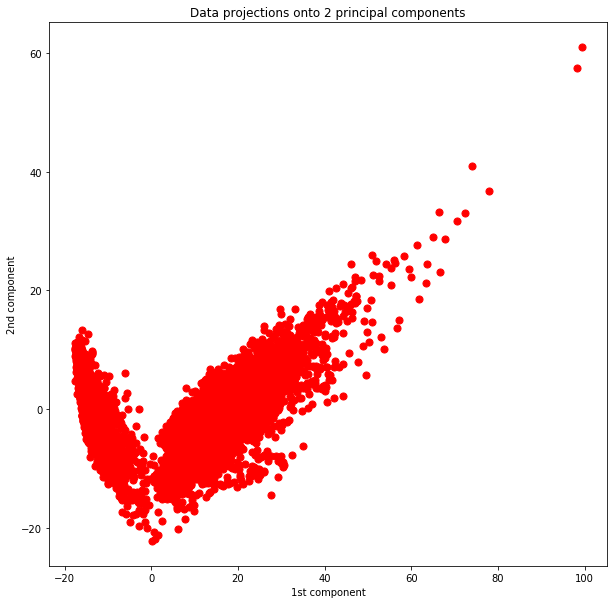

In [73]:
X_proj = X_scaled.dot(pca.components_[:2,:].transpose())
plt.figure(figsize=(10,10))
plt.scatter(X_proj[:, 0], X_proj[:, 1], s=50, c='r')
plt.title('Data projections onto 2 principal components')
plt.xlabel('1st component')
plt.ylabel('2nd component');

* Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью.  

In [78]:
X_reducted = pca.transform(X_scaled)

k_means = KMeans(n_clusters = n_clusters)
k_means = k_means.fit(X_reducted)
clusters = k_means.predict(X_reducted)

* Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

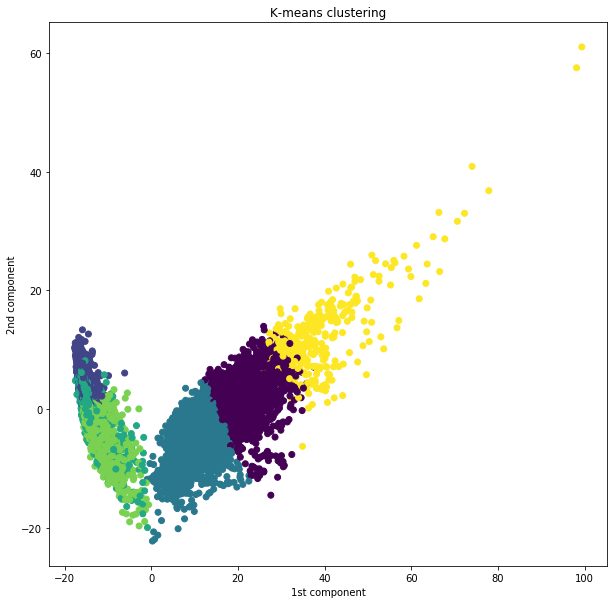

In [79]:

plt.figure(figsize=(10,10))
plt.scatter(X_reducted[:,0], X_reducted[:,1], c = clusters)
plt.title('K-means clustering')
plt.xlabel('1st component')
plt.ylabel('2nd component');

* Сделайте кластеризацию с помощью агломеративного метода. 

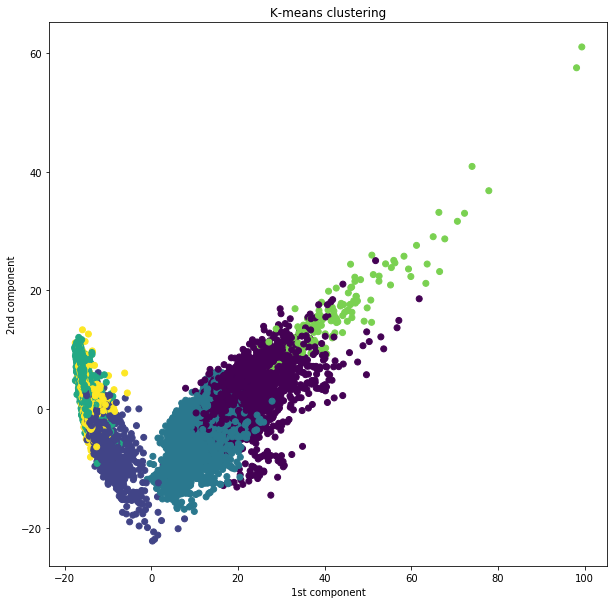

In [82]:
ag = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit_predict(X_reducted)

plt.figure(figsize=(10,10))
plt.scatter(X_reducted[:,0], X_reducted[:,1], c = ag)
plt.title('K-means clustering')
plt.xlabel('1st component')
plt.ylabel('2nd component');

* Cравните работу двух алгоритмов по значениям [Adjusted Rand Index (ARI)](https://en.wikipedia.org/wiki/Rand_index).

**Adjusted Rand Index (ARI)**

Предполагается, что известны истинные метки объектов. Данная мера не зависит от самих значений меток, а только от разбиения выборки на кластеры. Пусть $N$ - число объектов в выборке. Обозначим через $a$ - число пар объектов, имеющих одинаковые метки и находящихся в одном кластере, через $b$ - число пар объектов, имеющих различные метки и находящихся в разных кластерах. Тогда Rand Index это $$\text{RI} = \frac{2(a + b)}{n(n-1)}.$$ То есть это доля объектов, для которых эти разбиения (исходное и полученное в результате кластеризации) "согласованы". Rand Index (RI) выражает схожесть двух разных кластеризаций одной и той же выборки. Чтобы этот индекс давал значения близкие к нулю для случайных кластеризаций при любом $N$ и числе кластеров, необходимо нормировать его. Так определяется Adjusted Rand Index: $$\text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\max(\text{RI}) - E[\text{RI}]}.$$

Эта мера симметрична, не зависит от значений и перестановок меток. Таким образом, данный индекс является мерой расстояния между различными разбиениями выборки. $\text{ARI}$ принимает значения в диапазоне $[-1, 1]$. Отрицательные значения соответствуют "независимым" разбиениям на кластеры, значения, близкие к нулю, - случайным разбиениям, и положительные значения говорят о том, что два разбиения схожи (совпадают при $\text{ARI} = 1$).

In [83]:
from sklearn.metrics.cluster import adjusted_rand_score

In [85]:
print("ARI: {}".format(adjusted_rand_score(clusters, ag)))

ARI: 0.5731013874022773


Результаты класстеризации не идентичны, но сходства есть, лучше чем рандомное разбиение на классы